###  STRUCT

In [541]:
import numpy as np
import math
from math import log
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def kl (p,q): # Kullback-libler divegence
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)
    return np.sum(np.where(p != 0,(p-q) * np.log10(p / q), 0))
def jsd(p,q): # Symmetric Kullback-libler divergence
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)
    m = (p+q)/2
    return (kl(p,m)+kl(m,q))/2

def partition(Xtarget,ytarget,index_of_data,feature,C,threshold): # divide the data to the left and rightbased on the threshold
    left = index_of_data[Xtarget[index_of_data,feature]<threshold]
    labels_left = ytarget[left]
    QL = np.bincount(labels_left)
    
    right = index_of_data[Xtarget[index_of_data,feature]>=threshold]
    labels_right = ytarget[right]
    QR = np.bincount(labels_right)
    
    if(len(QL)<C):
        QL = np.append(QL,np.zeros(C-len(QL))) 
    if(len(QR)<C):
        QR = np.append(QR,np.zeros(C-len(QR))) 
    QL = QL/QL.sum()
    QR = QR/QR.sum()
    return [QL,left,QR,right]

def dg(Sleft,lenleft,Sright,lenright,QL,QR): # DG function as in the paper
    
    return 1-(lenleft/(lenleft+lenright))*jsd(Sleft,QL)-(lenright/(lenleft+lenright))*jsd(Sright,QR)
    
def threshold_selection(X,y,S,f,QL,QR,C): # finding the best threshold
    Val  = np.array([])
    fvals = np.sort(X[S,f])
    num_data_points = len(fvals)
    N = 50
    if num_data_points > N:            
        fvals = fvals[range(0,num_data_points,np.floor(num_data_points/N).astype(int))]
    for i in fvals:
        [Sleft, left, Sright, right] = partition(X,y,S,f,C,i)
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
        ax1.plot(QL)
        ax1.set_title('QL')
        ax2.plot(Sleft, color='r')
        ax2.set_title('QprimeL')
        ax3.plot(QR)
        ax3.set_title('QR')
        ax4.plot(Sright, color='r')
        ax4.set_title('QprimeR')
        Val = np.append(Val,min(dg(Sleft,len(left),Sright,len(right),QR,QL),dg(Sleft,len(left),Sright,len(right),QL,QR))) # this is the divergence measure for each threshold split  
    th = fvals[np.argmax(Val)]
    [ql, left, qr, right] = partition(X,y,S,f,C,th)
    return [th, ql, qr, left, right]
    
def STRUCT(Xsource,ysource,Xtarget,ytarget,C):
    # Assumption: ysource has all the labels of the problem 
    estimator = DecisionTreeClassifier(max_features='sqrt',max_leaf_nodes=3,random_state=0)
    estimator = estimator.fit(Xsource, ysource)
    P = list(np.zeros(estimator.tree_.capacity))
    P[0] = range(len(ytarget))
    thresh = np.zeros(estimator.tree_.capacity)
    remain = np.array([0])
    while(len(remain)!=0):
        i = remain[0]
        index_left = estimator.tree_.children_left[i]
        index_right = estimator.tree_.children_right[i]
        if(index_left!=-1):
            QL = np.squeeze(estimator.tree_.value[index_left])
            QL = QL/QL.sum()
            QR = np.squeeze(estimator.tree_.value[index_right])
            QR = QR/QR.sum()
            f = estimator.tree_.feature[i]
            [th, ql, qr, left, right] = threshold_selection(Xtarget,ytarget,np.array(P[i]),f,QL,QR,C)
            thresh[i] = th
            P[index_left] = left
            P[index_right] = right
            if(len(left)!=0):
                remain = np.append(remain,index_left)
            if(len(right)!=0):
                remain = np.append(remain,index_right)
        remain = remain[1:]
    return [thresh,P]

In [229]:
from sklearn.datasets import make_classification
from sklearn.cross_validation import train_test_split
import numpy as np
from __future__ import division
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../MNIST_data/", one_hot=False)
Xtrain = mnist.train.images
Xtest = mnist.test.images
ytrain = mnist.train.labels
ytest = mnist.test.labels
Xsource, Xtarget, ysource, ytarget = train_test_split(Xtrain, ytrain, test_size=0.5)
print Xtrain.shape
print Xtest.shape
print Xsource.shape
print Xtarget.shape
XT1,XT2,yT1,yT2 = train_test_split(Xtarget,ytarget,test_size=0.5)

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz
(55000, 784)
(10000, 784)
(27500, 784)
(27500, 784)


[ 0.02688582  0.02030042  0.10792424  0.12343529  0.13383041  0.07815391
  0.11788397  0.13970828  0.10988353  0.14199412]
409
0.00196078442968
0.0


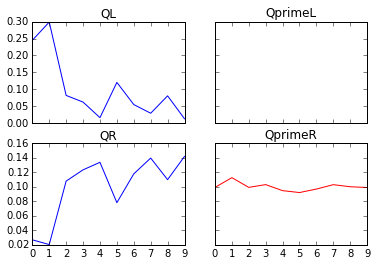

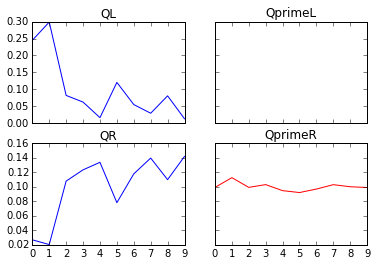

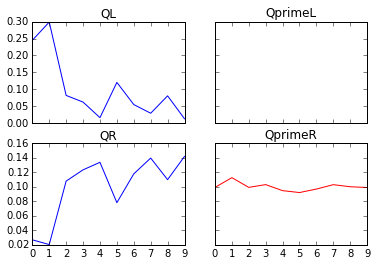

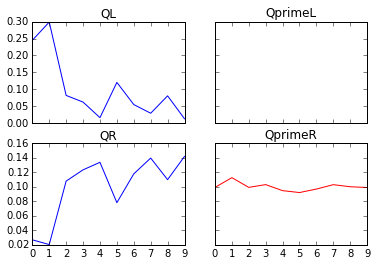

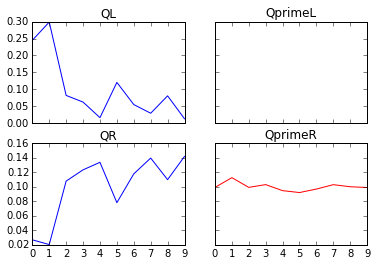

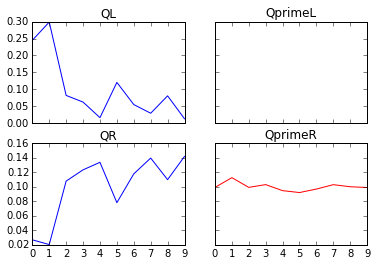

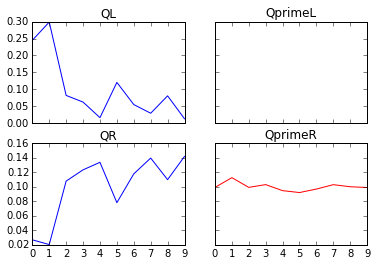

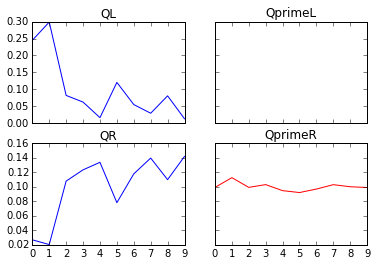

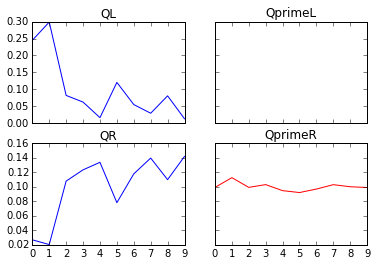

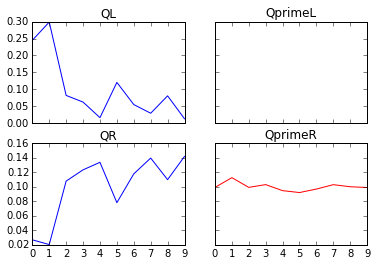

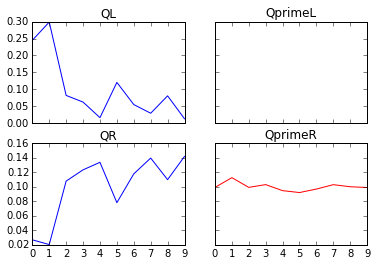

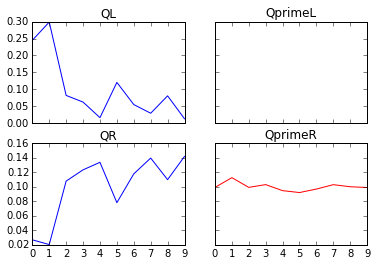

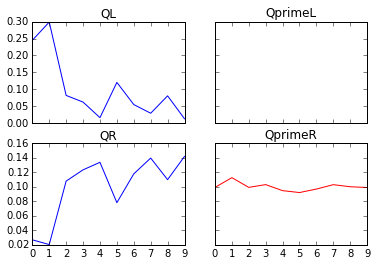

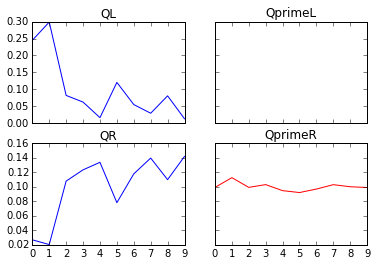

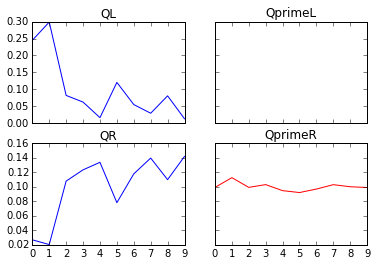

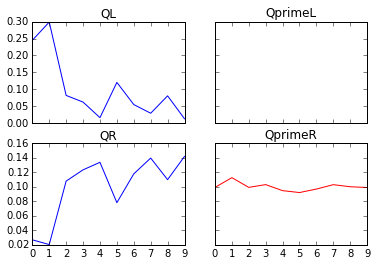

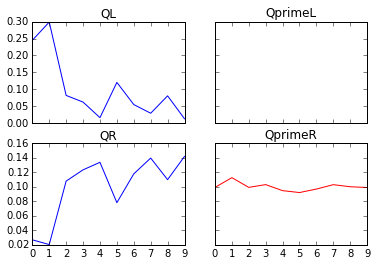

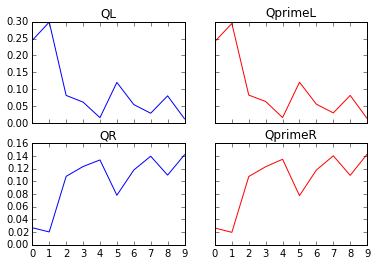

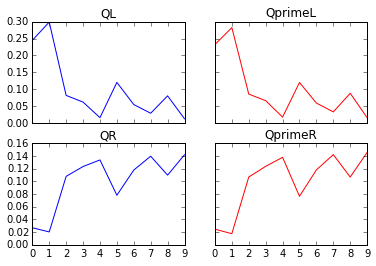

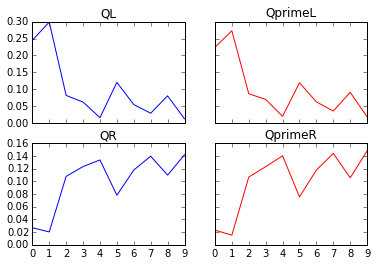

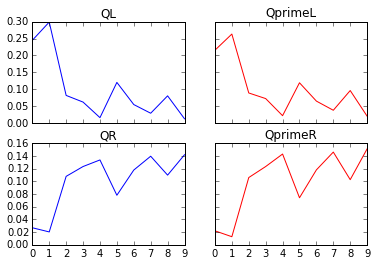

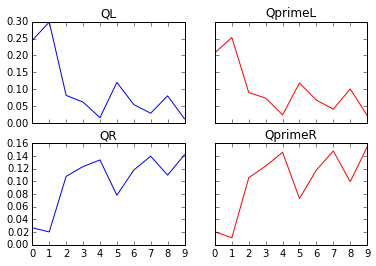

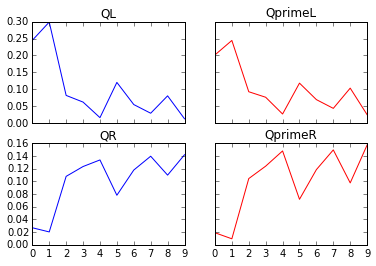

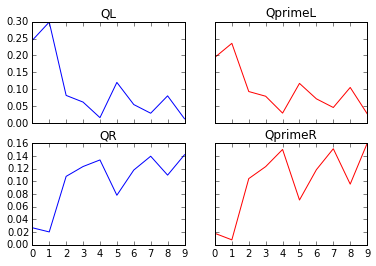

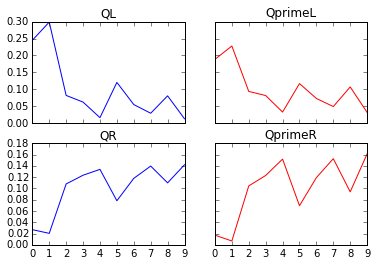

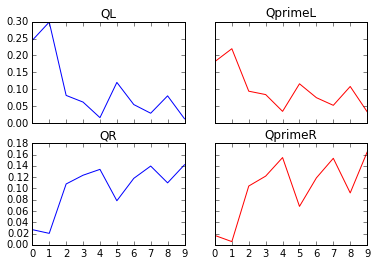

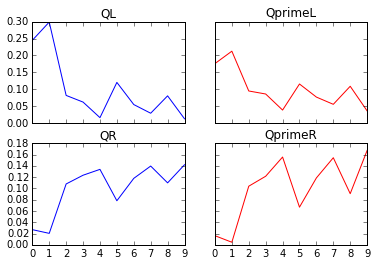

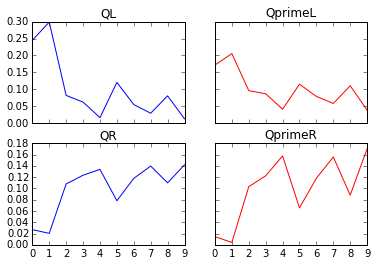

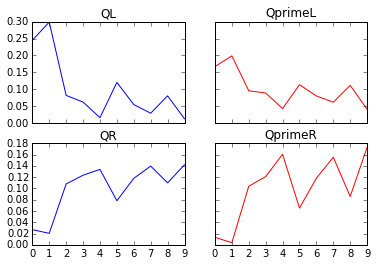

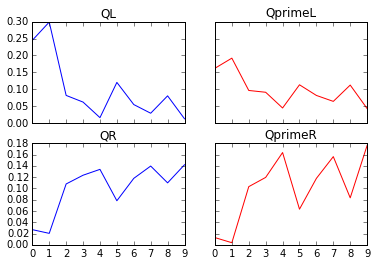

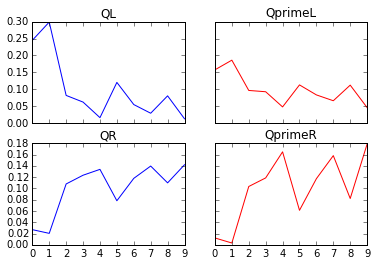

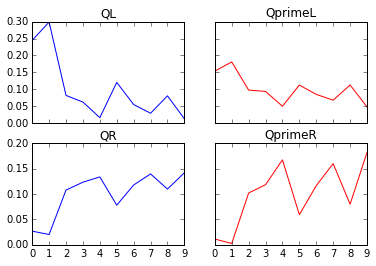

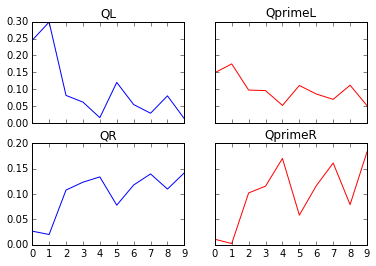

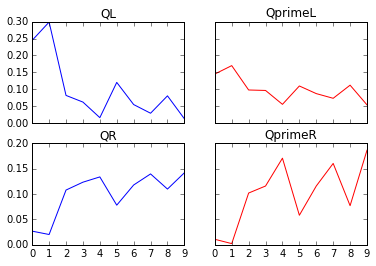

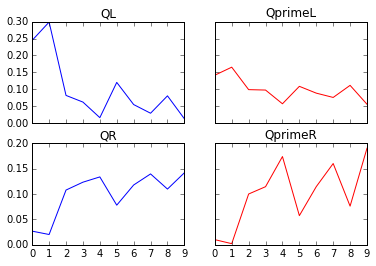

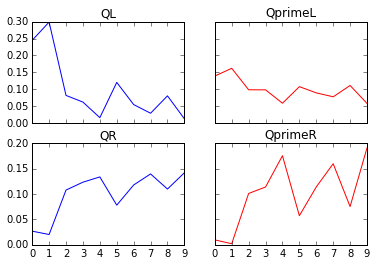

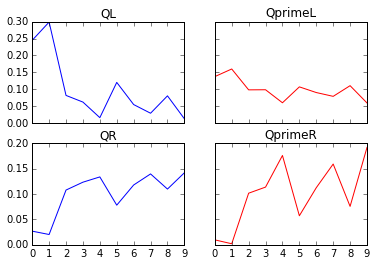

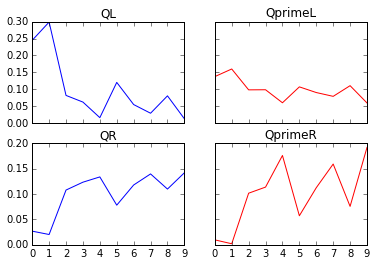

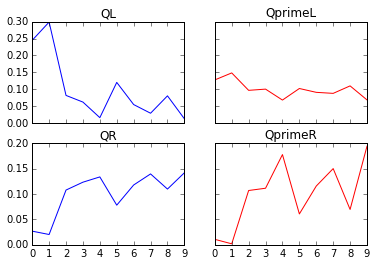

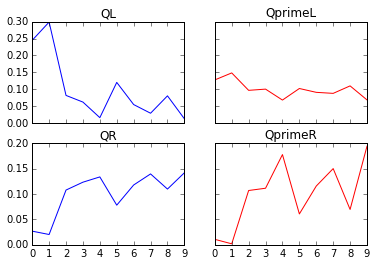

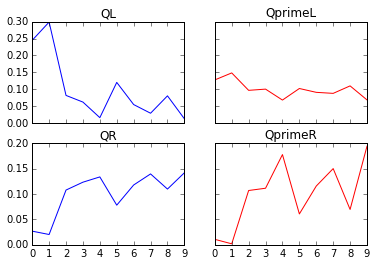

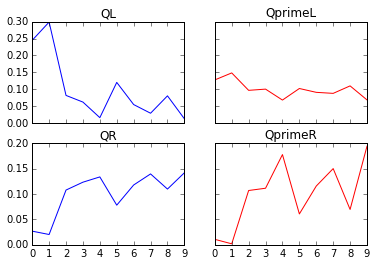

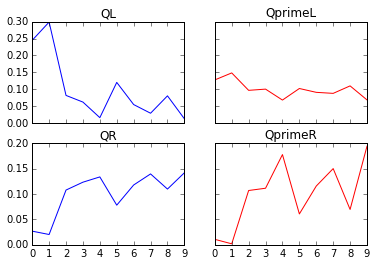

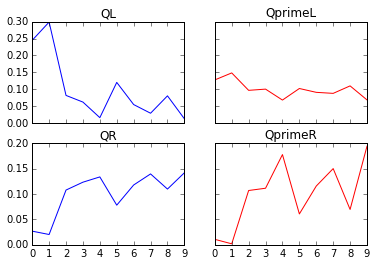

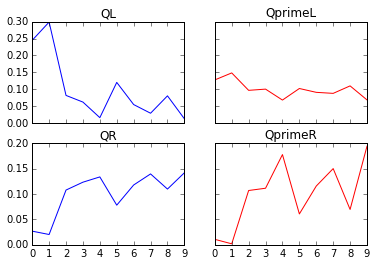

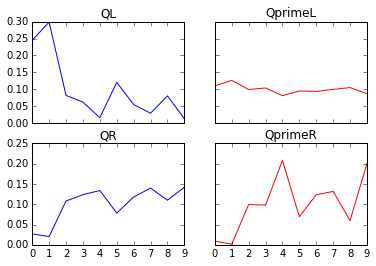

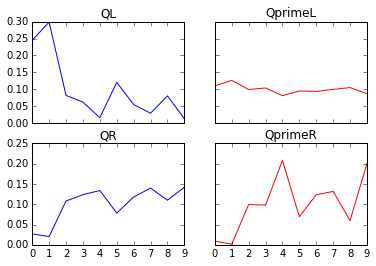

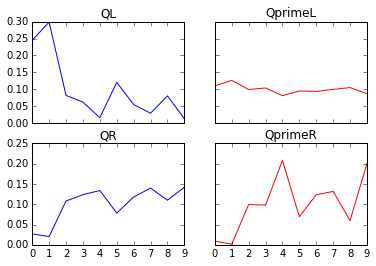

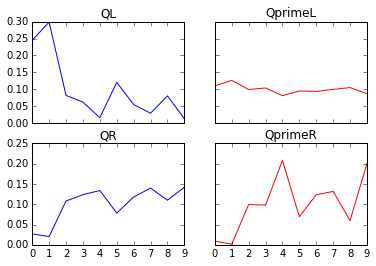

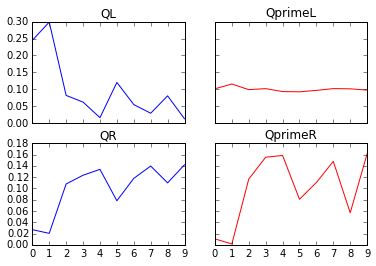

In [542]:
estimator = DecisionTreeClassifier(max_features='sqrt',max_leaf_nodes=3,random_state=0)
estimator = estimator.fit(Xsource, ysource)
[thresh,P] = STRUCT(Xsource,ysource,Xsource,ysource,10)
print estimator.tree_.feature[0]
print estimator.tree_.threshold[0]
print thresh[0]